In [27]:
import pandas as pd
import pm4py
import joblib
import xgboost as xgb

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [29]:
import shap
from SHAP_utils import calculateSHAP_values

In [30]:
original_log=pm4py.read_xes("./Data/road_traffic/Road_Traffic_Fine_Management_Process.xes")

parsing log, completed traces :: 100%|██████████| 150370/150370 [00:54<00:00, 2777.96it/s]


In [5]:
route="11-27-2025_22-49-29"
clf=joblib.load("./results/Ours/rtfm/"+route+"/clf_val0.2.joblib")

In [6]:
dataset=pd.read_csv("./Data/road_traffic/mined_rtfm_relabelled_confidences.csv",index_col=0)

In [7]:
dataset=dataset.set_index("case:concept:name")

In [8]:
X=dataset.drop(columns=["Class"])

y=dataset['Class']
print("No. of features:"+str(len(X.columns)))

le = LabelEncoder()
y_transformed = le.fit_transform(y)
le_name_mapping = pd.Series(dict(zip(le.classes_,le.transform(le.classes_))))
cols=X.columns.to_list()
X_train_and_validation, X_test, y_train_and_validation, y_test = train_test_split(X,
                                                                                  y_transformed,
                                                                                  test_size=0.2,
                                                                                  stratify=y_transformed,
                                                                                  shuffle=True,
                                                                                  random_state=0)

No. of features:2189


In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_validation,
                                                                y_train_and_validation,
                                                                test_size=0.2,
                                                                stratify=y_train_and_validation,
                                                                shuffle=True,
                                                                random_state=0)

In [10]:
le_name_mapping

collected     0
dismissed     1
fully_paid    2
unresolved    3
dtype: int32

In [11]:
shap_values_train, explainer_train=calculateSHAP_values(clf, X_train)

In [12]:
def returnProbs(instanceClassX, instanceClassY, classifier, classX, classY):
    matrix_classX=xgb.DMatrix(instanceClassX)
    probsInstanceX=classifier.predict(matrix_classX)
    probsInstanceX=probsInstanceX[0]*100
    print("Probabilities boundary trace of class "+classX+":")
    print("Class collected:"+str(round(probsInstanceX[0],5) )+";"+"Class dismissed:"+str(round(probsInstanceX[1],5))+ ";"+"Class fully paid:"+str(round(probsInstanceX[2],5))+ ";"+"Class Unresolved:"+str(round(probsInstanceX[3],5)) )
    
    matrix_classY=xgb.DMatrix(instanceClassY)
    probsInstanceY=classifier.predict(matrix_classY)
    probsInstanceY=probsInstanceY[0]*100
    print("Probabilities boundary trace of class "+classY+":")
    print("Class collected:"+str(round(probsInstanceY[0],5) )+";"+"Class dismissed:"+str(round(probsInstanceY[1],5))+ ";"+"Class fully paid:"+str(round(probsInstanceY[2],5))+ ";"+"Class Unresolved:"+str(round(probsInstanceY[3],5)) )

In [13]:
# 0-1-> collected vs dismissed

In [14]:
declare_measurements_boundary_cases_collected_and_dismissed=pd.read_csv("./results/Ours/rtfm/"+route+"/boundaryCases_Classescollected-dismissed.csv")

In [15]:
boundary_cases_collected_and_dismissed=dataset.loc[declare_measurements_boundary_cases_collected_and_dismissed["case:concept:name"]]
case_id_collected=boundary_cases_collected_and_dismissed[boundary_cases_collected_and_dismissed["Class"]=="collected"].index[0]

In [16]:
case_id_dismissed=boundary_cases_collected_and_dismissed[boundary_cases_collected_and_dismissed["Class"]=="dismissed"].index[0]

In [17]:
case_id_collected

'A26417'

In [18]:
instanceClassCollected=X.loc[[case_id_collected]]
instanceClassDismissed=X.loc[[case_id_dismissed]]
returnProbs(instanceClassCollected, instanceClassDismissed, clf, "collected", "dismissed")

Probabilities boundary trace of class collected:
Class collected:95.27489;Class dismissed:1.78261;Class fully paid:1.46654;Class Unresolved:1.47597
Probabilities boundary trace of class dismissed:
Class collected:3.7948;Class dismissed:55.57838;Class fully paid:3.81594;Class Unresolved:36.81088


In [19]:
#In none of the supposed boundary cases, there is closeness between collected probs and dismissed probs, therefore they are not boundary traces

In [20]:
#0-2->collected vs fully paid

In [22]:
declare_measurements_boundary_cases_collected_and_fullypaid=pd.read_csv("./results/Ours/rtfm/"+route+"/boundaryCases_Classescollected-fully_paid.csv")

In [23]:
boundary_cases_col_fp=dataset.loc[declare_measurements_boundary_cases_collected_and_fullypaid["case:concept:name"]]
case_id_collected_bccfp=boundary_cases_col_fp[boundary_cases_col_fp["Class"]=="collected"].index[0]
case_id_fully_paid_bccfp=boundary_cases_col_fp[boundary_cases_col_fp["Class"]=="fully_paid"].index[0]

In [24]:
dataset.loc[declare_measurements_boundary_cases_collected_and_fullypaid["case:concept:name"]][["Class"]]

,Class
case:concept:name,
S114128,collected
S162504,fully_paid


In [26]:
class0="collected"
class2="paid full"

instanceClassCollected_bccfp=X.loc[[case_id_collected_bccfp]]
instanceClassPaid_bccfp=X.loc[[case_id_fully_paid_bccfp]]
returnProbs(instanceClassCollected_bccfp, instanceClassPaid_bccfp, clf, class0, class2)

Probabilities boundary trace of class collected:
Class collected:95.27489;Class dismissed:1.78261;Class fully paid:1.46654;Class Unresolved:1.47597
Probabilities boundary trace of class paid full:
Class collected:3.43615;Class dismissed:3.44839;Class fully paid:47.6051;Class Unresolved:45.51038


In [22]:
#In none of the supposed boundary cases, there is closeness between collected probs and paid full probs, therefore they are not boundary traces

In [23]:
#0-3->collected vs unresolved

In [24]:
le_name_mapping

credit_collection    0
dismissed            1
paid_full            2
unresolved           3
dtype: int32

In [30]:
declare_measurements_boundary_cases_collected_and_unresolved=pd.read_csv("./results/Ours/rtfm/"+route+"/boundaryCases_Classescollected-unresolved.csv")

In [31]:
boundary_cases_collected_and_unresolved=dataset.loc[declare_measurements_boundary_cases_collected_and_unresolved["case:concept:name"]]
case_id_collected=boundary_cases_collected_and_unresolved[boundary_cases_collected_and_unresolved["Class"]=="collected"].index[0]
case_id_unresolved=boundary_cases_collected_and_unresolved[boundary_cases_collected_and_unresolved["Class"]=="unresolved"].index[0]

In [32]:
dataset.loc[declare_measurements_boundary_cases_collected_and_unresolved["case:concept:name"]][["Class"]]

,Class
case:concept:name,
N99647,collected
S120795,unresolved


In [36]:
class0="collected"
class3="unresolved"

instanceClassCollected=X.loc[[case_id_collected]]
instanceClassUnresolved=X.loc[[case_id_unresolved]]
returnProbs(instanceClassCollected, instanceClassUnresolved, clf, class0, class3)

Probabilities boundary trace of class collected:
Class collected:95.18583;Class dismissed:1.87442;Class fully paid:1.46517;Class Unresolved:1.47459
Probabilities boundary trace of class unresolved:
Class collected:4.07564;Class dismissed:44.19042;Class fully paid:4.09835;Class Unresolved:47.6356


In [26]:
#In none of the supposed boundary cases, there is closeness between collected probs and unresolved probs, therefore they are not boundary traces

In [28]:
# 1-2-> dismissed vs paid full

In [37]:
declare_measurements_boundary_cases_dismissed_and_fullypaid=pd.read_csv("./results/Ours/rtfm/"+route+"/boundaryCases_Classesdismissed-fully_paid.csv")

In [38]:
boundary_cases_dismissed_and_fullypaid=dataset.loc[declare_measurements_boundary_cases_dismissed_and_fullypaid["case:concept:name"]]
case_id_dismissed=boundary_cases_dismissed_and_fullypaid[boundary_cases_dismissed_and_fullypaid["Class"]=="dismissed"].index[0]
case_id_fully_paid=boundary_cases_dismissed_and_fullypaid[boundary_cases_dismissed_and_fullypaid["Class"]=="fully_paid"].index[0]

In [39]:
dataset.loc[declare_measurements_boundary_cases_dismissed_and_fullypaid["case:concept:name"]][["Class"]]

,Class
case:concept:name,
S84815,dismissed
S77183,fully_paid


In [42]:
class1="Dismissed"
class2="Fully paid"

instanceClassDismissed=X.loc[[case_id_dismissed]]
instanceClassPaid=X.loc[[case_id_fully_paid]]
returnProbs(instanceClassDismissed, instanceClassPaid, clf, class1, class2)

Probabilities boundary trace of class Dismissed:
Class collected:3.7948;Class dismissed:55.57838;Class fully paid:3.81594;Class Unresolved:36.81088
Probabilities boundary trace of class Fully paid:
Class collected:3.71702;Class dismissed:3.73026;Class fully paid:51.49638;Class Unresolved:41.05634


In [43]:
#In none of the supposed boundary cases, there is closeness between dismissed probs and fully paid probs, therefore they are not boundary traces

In [44]:
#1-3->dismissed vs unresolved

In [47]:
declare_measurements_boundary_cases_dismissed_and_unresolved=pd.read_csv("./results/Ours/rtfm/"+route+"/boundaryCases_Classesdismissed-unresolved.csv")

In [49]:
boundary_cases_dismissed_and_unresolved=dataset.loc[declare_measurements_boundary_cases_dismissed_and_unresolved["case:concept:name"]]
case_id_dismissed_bcdu=boundary_cases_dismissed_and_unresolved[boundary_cases_dismissed_and_unresolved["Class"]=="dismissed"].index[0]
case_id_unresolved_bcdu=boundary_cases_dismissed_and_unresolved[boundary_cases_dismissed_and_unresolved["Class"]=="unresolved"].index[0]

In [50]:
declare_measurements_boundary_cases_dismissed_and_unresolved

,case:concept:name,"'ChainPrecedence(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)'","'AlternatePrecedence(Appeal to Judge, Payment)'",'Absence(Send for Credit Collection)',"'ChainPrecedence(Add penalty, Notify Result Appeal to Offender)'","'AlternatePrecedence(Appeal to Judge, Add penalty)'","'AlternatePrecedence(Add penalty, Receive Result Appeal from Prefecture)'","'AlternatePrecedence(Add penalty, Insert Date Appeal to Prefecture)'","'ChainPrecedence(Insert Date Appeal to Prefecture, Payment)'","'AlternatePrecedence(Appeal to Judge, Send Appeal to Prefecture)'",...,"'ChainPrecedence(Insert Date Appeal to Prefecture, Insert Fine Notification)'","'AlternateResponse(Send Appeal to Prefecture, Notify Result Appeal to Offender)'","'ChainPrecedence(Send Appeal to Prefecture, Add penalty)'","'AlternateResponse(Payment, Add penalty)'","'ChainResponse(Payment, Add penalty)'","'ChainPrecedence(Insert Fine Notification, Payment)'",'End(Receive Result Appeal from Prefecture)',"'AlternateResponse(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)'","'ChainResponse(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)'","'ChainPrecedence(Add penalty, Payment)'"
0,S84815,100.0,-100.0,100.0,-100.0,0.0,-100.0,100.0,-100.0,0.0,...,0.0,0.0,0.0,-100.0,-100.0,-100.0,0.0,100.0,100.0,-100.0
1,S124255,100.0,-100.0,100.0,0.0,0.0,100.0,100.0,-100.0,0.0,...,0.0,100.0,0.0,-100.0,-100.0,-100.0,0.0,100.0,100.0,-100.0


In [53]:
dataset.loc[declare_measurements_boundary_cases_dismissed_and_unresolved["case:concept:name"]][["Class"]]

,Class
case:concept:name,
S84815,dismissed
S124255,unresolved


In [59]:
class1="Dismissed"
class3="Unresolved"

instanceClassDismissed_bcdu=X.loc[[case_id_dismissed_bcdu]]
instanceClassUnresolved_bcdu=X.loc[[case_id_unresolved_bcdu]]
returnProbs(instanceClassDismissed_bcdu, instanceClassUnresolved_bcdu, clf, class1, class3)

Probabilities boundary trace of class Dismissed:
Class collected:3.7948;Class dismissed:55.57838;Class fully paid:3.81594;Class Unresolved:36.81088
Probabilities boundary trace of class Unresolved:
Class collected:4.07564;Class dismissed:44.19042;Class fully paid:4.09835;Class Unresolved:47.6356


In [60]:
def plotTop10features(shap_values, case, X, classCase, explainer):
    index_instance_class=X.index.get_indexer([case])[0]
    shap_values_best_instance=shap_values[classCase][index_instance_class]
    expected_value=explainer.expected_value[classCase]#expected value of the class
    class_instance_all_values=X.loc[case]
    shap.waterfall_plot(shap.Explanation(values=shap_values_best_instance, 
                                     base_values=expected_value, 
                                     data=class_instance_all_values),
                                     max_display=10,
                                     show=True)

In [62]:
#dismissed case
original_log[original_log["case:concept:name"]==instanceClassDismissed_bcdu.index[0]]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
511748,33.60,46,NIL,Create Fine,A,0.0,complete,2003-08-21 00:00:00+00:00,7.0,0.0,S84815,NaN,NaN,NaN,NaN,NaN
511749,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2003-11-10 00:00:00+00:00,NaN,NaN,S84815,10.0,NaN,NaN,NaN,NaN
511750,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2003-11-15 00:00:00+00:00,NaN,NaN,S84815,NaN,P,N,NaN,NaN
511751,68.77,NaN,NaN,Add penalty,NaN,NaN,complete,2004-01-14 00:00:00+00:00,NaN,NaN,S84815,NaN,NaN,NaN,NaN,NaN
511752,NaN,NaN,NaN,Insert Date Appeal to Prefecture,NaN,NaN,complete,2004-01-15 00:00:00+00:00,NaN,NaN,S84815,NaN,NaN,NaN,NaN,NaN
511753,NaN,NaN,#,Send Appeal to Prefecture,NaN,NaN,complete,2004-03-10 00:00:00+00:00,NaN,NaN,S84815,NaN,NaN,NaN,NaN,NaN


In [63]:
#unresolved case
original_log[original_log["case:concept:name"]==instanceClassUnresolved_bcdu.index[0]]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
317459,36.0,53,NIL,Create Fine,A,0.0,complete,2008-03-06 00:00:00+00:00,7.0,0.0,S124255,NaN,NaN,NaN,NaN,NaN
317460,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2008-06-04 00:00:00+00:00,NaN,NaN,S124255,26.0,NaN,NaN,NaN,NaN
317461,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2008-06-10 00:00:00+00:00,NaN,NaN,S124255,NaN,P,P,NaN,NaN
317462,74.0,NaN,NaN,Add penalty,NaN,NaN,complete,2008-08-09 00:00:00+00:00,NaN,NaN,S124255,NaN,NaN,NaN,NaN,NaN
317463,NaN,NaN,NaN,Insert Date Appeal to Prefecture,NaN,NaN,complete,2008-09-22 00:00:00+00:00,NaN,NaN,S124255,NaN,NaN,NaN,NaN,NaN
317464,NaN,NaN,#,Send Appeal to Prefecture,NaN,NaN,complete,2008-11-28 00:00:00+00:00,NaN,NaN,S124255,NaN,NaN,NaN,NaN,NaN
317465,NaN,NaN,NaN,Receive Result Appeal from Prefecture,NaN,NaN,complete,2008-12-04 00:00:00+00:00,NaN,NaN,S124255,NaN,NaN,NaN,NaN,NaN
317466,NaN,NaN,NaN,Notify Result Appeal to Offender,NaN,NaN,complete,2008-12-10 00:00:00+00:00,NaN,NaN,S124255,NaN,NaN,NaN,NaN,NaN
317467,NaN,0,NIL,Appeal to Judge,NaN,NaN,complete,2009-01-07 00:00:00+00:00,NaN,NaN,S124255,NaN,NaN,NaN,NaN,0.0


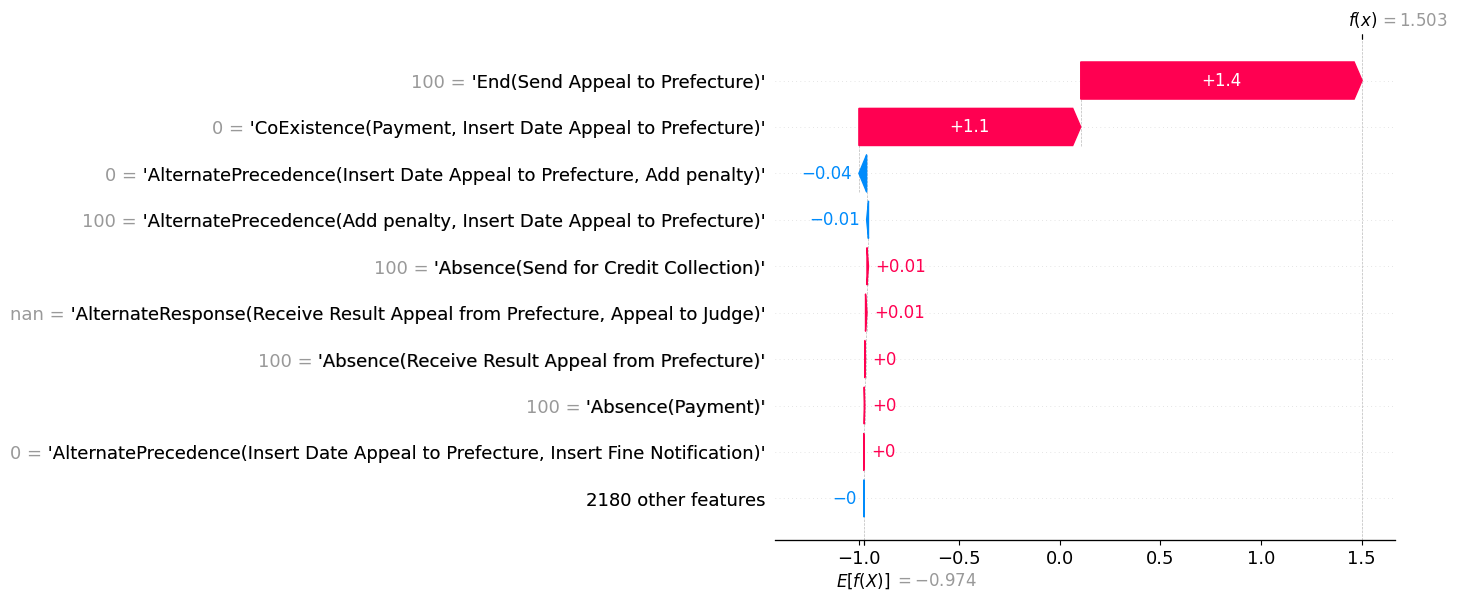

In [64]:
plotTop10features(shap_values=shap_values_train,
                  case=instanceClassDismissed_bcdu.index[0],
                  classCase=1, 
                  X=X_train,
                  explainer=explainer_train)

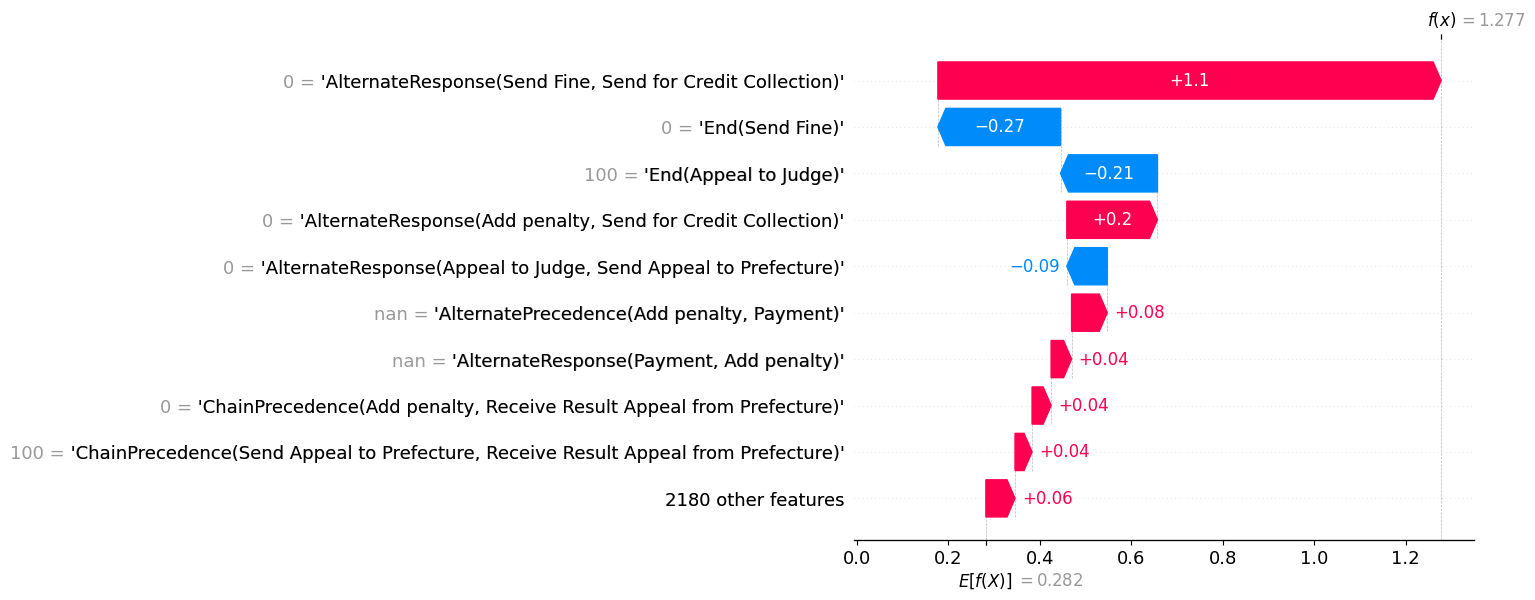

In [65]:
plotTop10features(shap_values=shap_values_train,
                  case=instanceClassUnresolved_bcdu.index[0],
                  classCase=3, 
                  X=X_train,
                  explainer=explainer_train)

In [43]:
#2-3-> paid full vs unresolved

In [67]:
declare_measurements_boundary_casesfully_paid_and_unresolved=pd.read_csv("./results/Ours/rtfm/"+route+"/boundaryCases_Classesfully_paid-unresolved.csv")

In [68]:
declare_measurements_boundary_casesfully_paid_and_unresolved

,case:concept:name,"'ChainPrecedence(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)'","'AlternatePrecedence(Appeal to Judge, Payment)'",'Absence(Send for Credit Collection)',"'ChainPrecedence(Add penalty, Notify Result Appeal to Offender)'","'AlternatePrecedence(Appeal to Judge, Add penalty)'","'AlternatePrecedence(Add penalty, Receive Result Appeal from Prefecture)'","'AlternatePrecedence(Add penalty, Insert Date Appeal to Prefecture)'","'ChainPrecedence(Insert Date Appeal to Prefecture, Payment)'","'AlternatePrecedence(Appeal to Judge, Send Appeal to Prefecture)'",...,"'ChainPrecedence(Insert Date Appeal to Prefecture, Insert Fine Notification)'","'AlternateResponse(Send Appeal to Prefecture, Notify Result Appeal to Offender)'","'ChainPrecedence(Send Appeal to Prefecture, Add penalty)'","'AlternateResponse(Payment, Add penalty)'","'ChainResponse(Payment, Add penalty)'","'ChainPrecedence(Insert Fine Notification, Payment)'",'End(Receive Result Appeal from Prefecture)',"'AlternateResponse(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)'","'ChainResponse(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)'","'ChainPrecedence(Add penalty, Payment)'"
0,S77183,100.0,0.0,100.0,-100.0,0.0,-100.0,0.0,0.0,0.0,...,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0
1,V10030,100.0,0.0,100.0,-100.0,0.0,-100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0


In [69]:
dataset.loc[declare_measurements_boundary_casesfully_paid_and_unresolved["case:concept:name"]][["Class"]]

,Class
case:concept:name,
S77183,fully_paid
V10030,unresolved


In [70]:
boundary_cases_fullypaid_and_unresolved=dataset.loc[declare_measurements_boundary_casesfully_paid_and_unresolved["case:concept:name"]]
case_id_fully_paid_bcfu=boundary_cases_fullypaid_and_unresolved[boundary_cases_fullypaid_and_unresolved["Class"]=="fully_paid"].index[0]
case_id_unresolved_bcfu=boundary_cases_fullypaid_and_unresolved[boundary_cases_fullypaid_and_unresolved["Class"]=="unresolved"].index[0]

In [72]:
class2="Full paid"
class3="Unresolved"

instanceClassFullPaid_bcfu=X.loc[[case_id_fully_paid_bcfu]]
instanceClassUnresolved_bcfu=X.loc[[case_id_unresolved_bcfu]]
returnProbs(instanceClassFullPaid_bcfu, instanceClassUnresolved_bcfu, clf, class2, class3)

Probabilities boundary trace of class Full paid:
Class collected:3.71702;Class dismissed:3.73026;Class fully paid:51.49638;Class Unresolved:41.05634
Probabilities boundary trace of class Unresolved:
Class collected:3.96058;Class dismissed:3.97469;Class fully paid:45.3954;Class Unresolved:46.66932


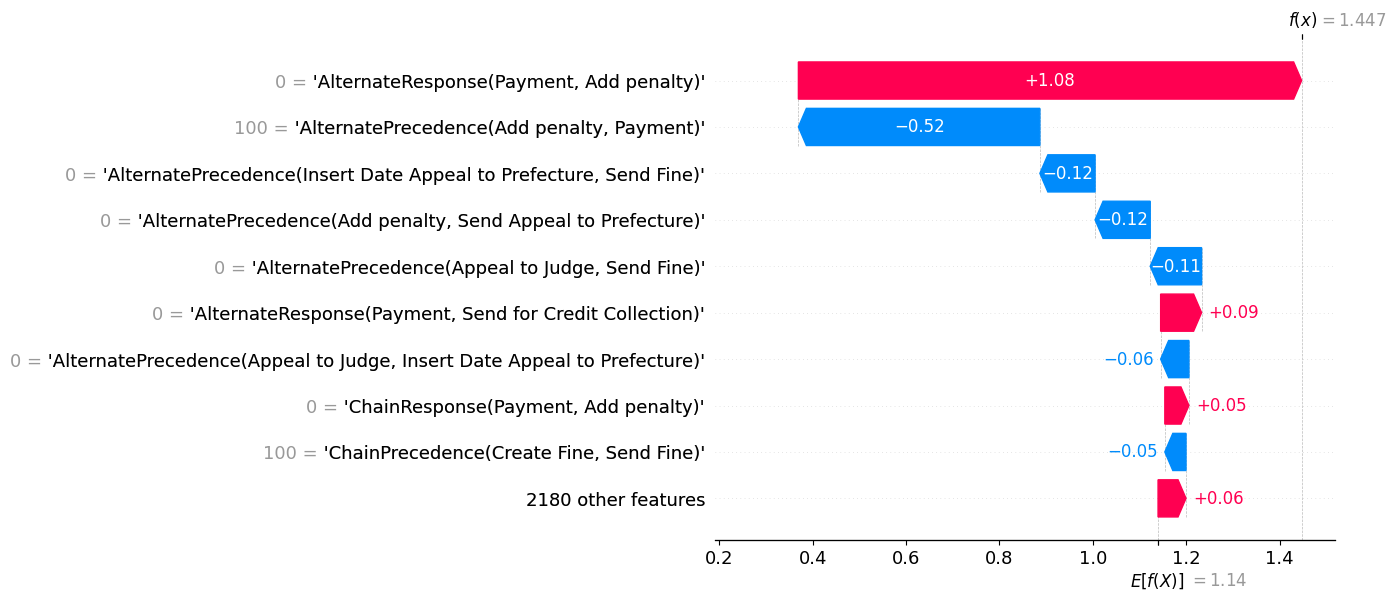

In [73]:
plotTop10features(shap_values=shap_values_train,
                  case=case_id_fully_paid_bcfu,#paid
                  classCase=2, 
                  X=X_train,
                  explainer=explainer_train)

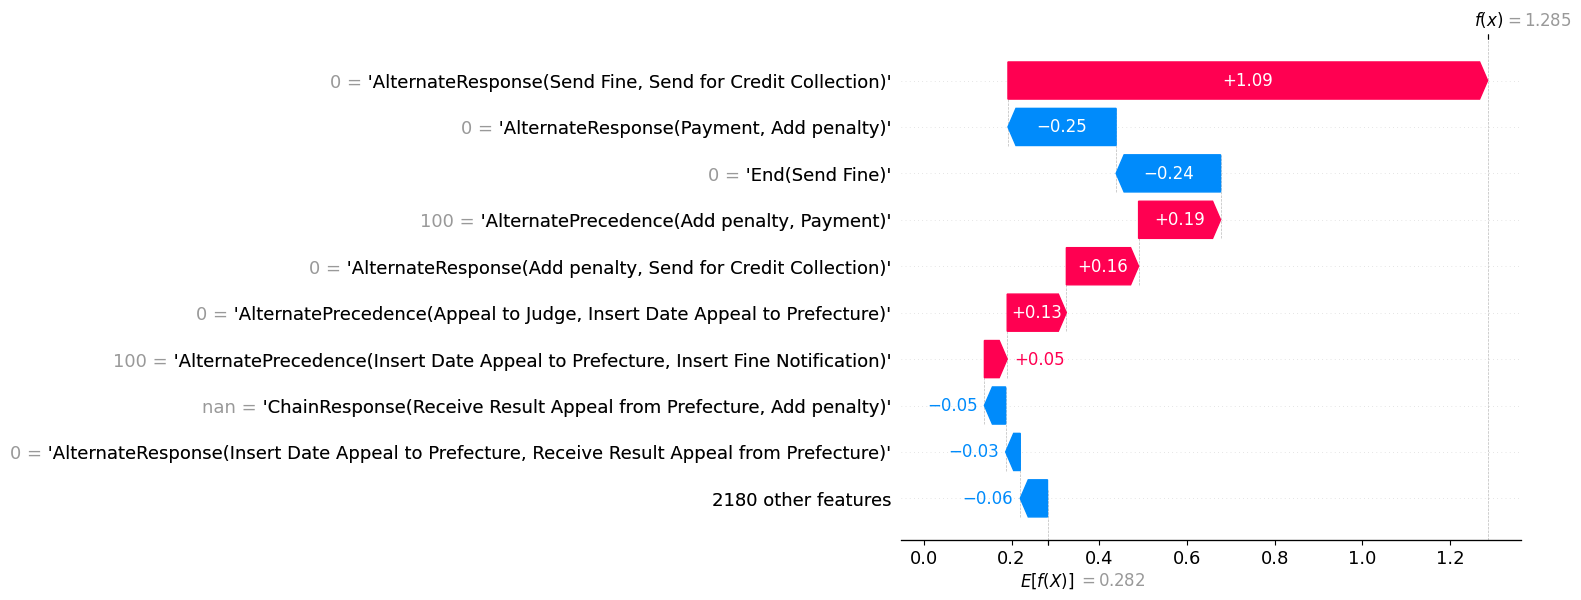

In [74]:
plotTop10features(shap_values=shap_values_train,
                  case=case_id_unresolved_bcfu,#unresolved
                  classCase=3, 
                  X=X_train,
                  explainer=explainer_train)

In [75]:
original_log[original_log["case:concept:name"]==case_id_unresolved_bcfu]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
533681,131.0,839,NIL,Create Fine,A,0.0,complete,2002-09-10 00:00:00+00:00,142.0,0.0,V10030,NaN,NaN,NaN,NaN,NaN
533682,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V10030,10.0,NaN,NaN,NaN,NaN
533683,NaN,NaN,NaN,Insert Date Appeal to Prefecture,NaN,NaN,complete,2002-11-02 00:00:00+00:00,NaN,NaN,V10030,NaN,NaN,NaN,NaN,NaN
533684,NaN,NaN,NIL,Send Appeal to Prefecture,NaN,NaN,complete,2002-11-03 00:00:00+00:00,NaN,NaN,V10030,NaN,NaN,NaN,NaN,NaN
533685,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V10030,NaN,P,N,NaN,NaN
533686,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V10030,NaN,NaN,NaN,NaN,NaN
533687,NaN,NaN,NaN,Payment,NaN,131.0,complete,2004-02-23 00:00:00+00:00,NaN,NaN,V10030,NaN,NaN,NaN,131.0,NaN


In [76]:
original_log[original_log["case:concept:name"]==case_id_fully_paid_bcfu]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
499094,32.0,838,NIL,Create Fine,A,0.0,complete,2002-09-20 00:00:00+00:00,7.0,0.0,S77183,NaN,NaN,NaN,NaN,NaN
499095,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-11-23 00:00:00+00:00,NaN,NaN,S77183,10.0,NaN,NaN,NaN,NaN
499096,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-12-12 00:00:00+00:00,NaN,NaN,S77183,NaN,P,N,NaN,NaN
499097,NaN,NaN,NaN,Insert Date Appeal to Prefecture,NaN,NaN,complete,2002-12-13 00:00:00+00:00,NaN,NaN,S77183,NaN,NaN,NaN,NaN,NaN
499098,NaN,NaN,NIL,Send Appeal to Prefecture,NaN,NaN,complete,2002-12-14 00:00:00+00:00,NaN,NaN,S77183,NaN,NaN,NaN,NaN,NaN
499099,65.5,NaN,NaN,Add penalty,NaN,NaN,complete,2003-02-10 00:00:00+00:00,NaN,NaN,S77183,NaN,NaN,NaN,NaN,NaN
499100,NaN,NaN,NaN,Payment,NaN,75.5,complete,2003-05-20 00:00:00+00:00,NaN,NaN,S77183,NaN,NaN,NaN,75.5,NaN
